# TODO

1. Gráficos para exploração de dados
 - tendência?
 - sazonalidade?
 - 
 
# Resources
- sarima lento a 365 dias - https://github.com/statsmodels/statsmodels/issues/5727

In [53]:
# data & viz
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.tseries.offsets import DateOffset


# tsf
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm  
from statsmodels.tsa.stattools import acf, pacf

from statsmodels.tsa.arima.model import ARIMA, ARIMAResults

from statsmodels.tsa.statespace.sarimax import SARIMAX

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error 
from sklearn.metrics import mean_absolute_error

#
from sklearn.metrics import mean_squared_error
from math import sqrt

# 1. Objetivos

Endereço do dataset:
https://www.kaggle.com/datasets/surajjha101/analyzing-and-prediction-of-bitcoin-pricing?resource=download

# 2. Data loading and preparation

In [54]:
fn = 'data/BTC-USD.csv'

In [55]:
df = pd.read_csv(fn, index_col='Date', parse_dates=True)
df.index.freq = 'D'

A frequência dos dados é diária.
Vamos dar essa indicação na estrutura de dados.

Os objetivos propostos para a análise são:
1. previsão da evolução do preço de fecho diário a 30 dias
2. previsão da evolução do preço médio semanal a 1 ano

# 3. Preço de "fecho"

Vamos começar por analisar o preço de "fecho" (criptomoedas não têm um momento de encerramento de transações, como outros instrumentos financeiros tradicionais, e.g. ações).

In [56]:
df.columns

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')

In [75]:
dfX = df.drop(columns=['Open', 'High', 'Low', 'Adj Close', 'Volume'])


lags = 30
period = 365
ma_window = 30

## 3.1. Exploração dos dados

In [58]:
dfX.Close.plot(figsize=(12,8), title='Daily Close price', label='price', legend=True)
dfX.Close.rolling(window=ma_window).mean().dropna().plot(label=f'moving average {ma_window}', legend=True)


<AxesSubplot:title={'center':'Weekly Close price'}, xlabel='Date'>

In [59]:
dfX.Close.groupby(dfX.index.dayofyear).mean().plot(figsize=(12,8), title='Average close price per day of the year')



dfX_x = dfX.Close.loc[:'2021']
dfX_x.groupby(dfX_x.index.dayofyear).mean().plot(figsize=(12,8), label='Before 2021')


plt.legend()


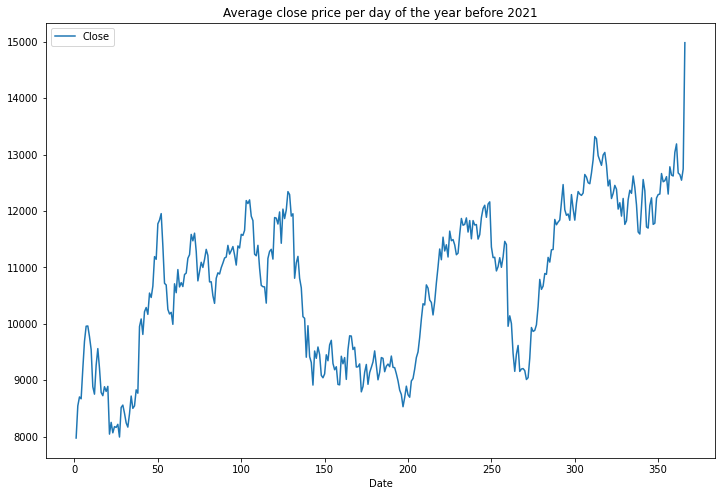

In [60]:
dfX_x = dfX.Close.loc[:'2021']
dfX_x.groupby(dfX_x.index.dayofyear).mean().plot(figsize=(12,8), title='Average close price per day of the year before 2021')
plt.legend()

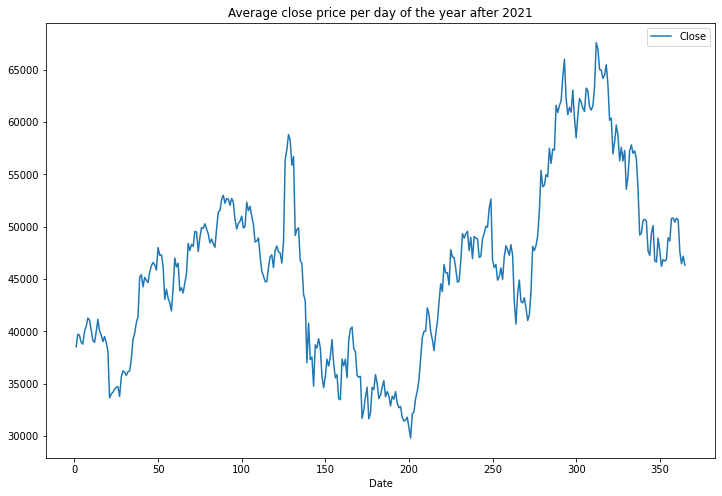

In [61]:
dfX_x = dfX.Close.loc['2021':]
dfX_x.groupby(dfX_x.index.dayofyear).mean().plot(figsize=(12,8), title='Average close price per day of the year after 2021')
plt.legend()


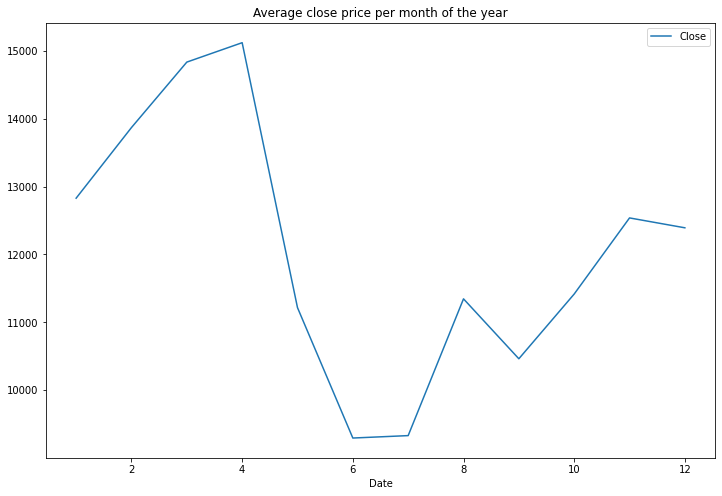

In [62]:
dfX.Close.groupby(dfX.Close.index.month).mean().plot(figsize=(12,8), title='Average close price per month of the year')
plt.legend()

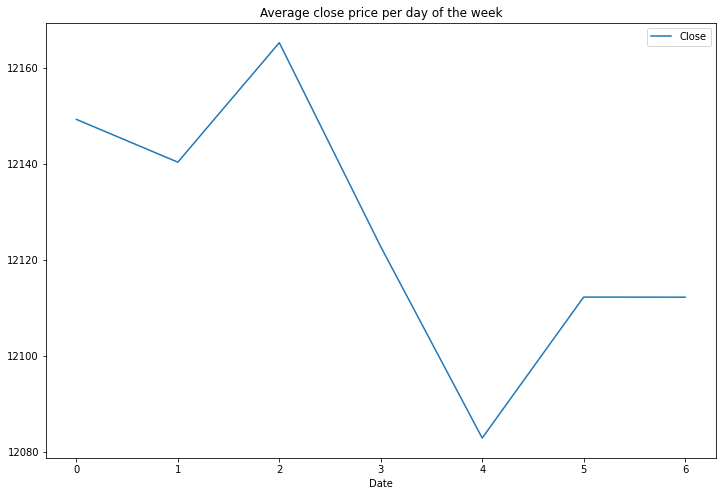

In [63]:
dfX.Close.groupby(dfX.Close.index.dayofweek).mean().plot(figsize=(12,8), title='Average close price per day of the week')
plt.legend()

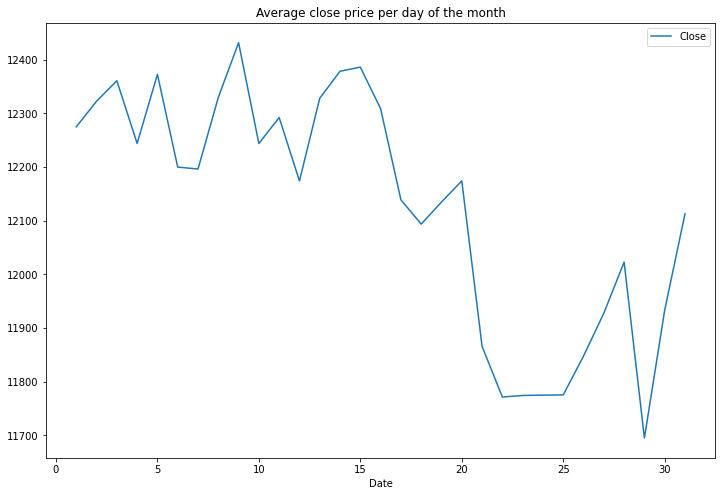

In [64]:
dfX.Close.groupby(dfX.Close.index.day).mean().plot(figsize=(12,8), title='Average close price per day of the month')
plt.legend()

## 3.2. Decompor série

In [65]:
#Decomposition
decomposition = sm.tsa.seasonal_decompose(dfX.Close,
                                          model='multiplicative',
                                          period=period)
plt.rcParams["figure.figsize"] = [16,8]
decomposition.plot()

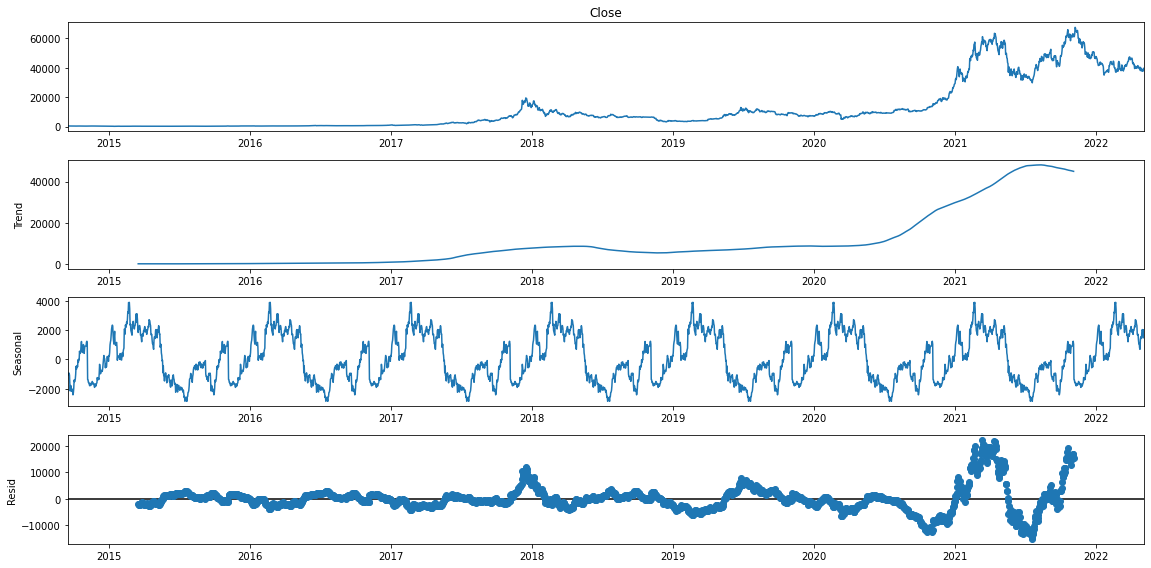

In [66]:
#Decomposition
decomposition = sm.tsa.seasonal_decompose(dfX.Close,
                                          model='additive',
                                          period=period)
plt.rcParams["figure.figsize"] = [16,8]
fig = decomposition.plot()


## 3.3. ACF, PACF e estacionariedade

In [17]:
# Unit root tests
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
        

        
def stationary_tests(x, comment=''):
    print('\t', comment, '\n')
    print(adf_test(x))
    print(kpss_test(x))
    
def visualize_ts(x: pd.DataFrame, prefix='', lags=30):
    # Plot data
    x.plot(figsize=(12,8), title= f'{prefix} Close price', fontsize=14)

    # Compute Sample ACF and Sample PACF
    fig0 = plt.figure(figsize=(12,8))
    ax1 = fig0.add_subplot(211)
    fig0 = sm.graphics.tsa.plot_acf(x, lags=lags, ax=ax1)
    ax2 = fig0.add_subplot(212)
    fig0 = sm.graphics.tsa.plot_pacf(x, lags=lags, ax=ax2)
    
    adf_test(x)
    
    
def apply_one_difference(x):
    dfX_1st_diff = x - x.shift(1)  
    return dfX_1st_diff.dropna(inplace=False)

def apply_difference(x, p=1):
    ts_diff = x - x.shift(p)  
    return ts_diff.dropna(inplace=False)

def apply_differences(x, n_diff):
    y = x
    for i in range(n_diff):
        y = apply_one_difference(y)
        print(y.shape)
    return y

In [18]:
data_transformations = {
    'original': dfX.Close,
    'log': dfX.Close.map(np.log),
    'diff_1': apply_difference(dfX.Close, 1),
    'diff_1_log': apply_difference(dfX.Close.map(np.log), 1),
    'diff_saz': apply_difference(dfX.Close, period),
    'diff_saz_log': apply_difference(dfX.Close.map(np.log), period),
    'diff_saz_diff_1': apply_difference(apply_difference(dfX.Close, 1)),
    'diff_saz_diff_1_log': apply_difference(apply_difference(dfX.Close.map(np.log), 1), period)
}

### 3.3.1. Série original

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                   -1.133877
p-value                           0.701375
#Lags Used                       28.000000
Number of Observations Used    2759.000000
Critical Value (1%)              -3.432722
Critical Value (5%)              -2.862588
Critical Value (10%)             -2.567328
dtype: float64


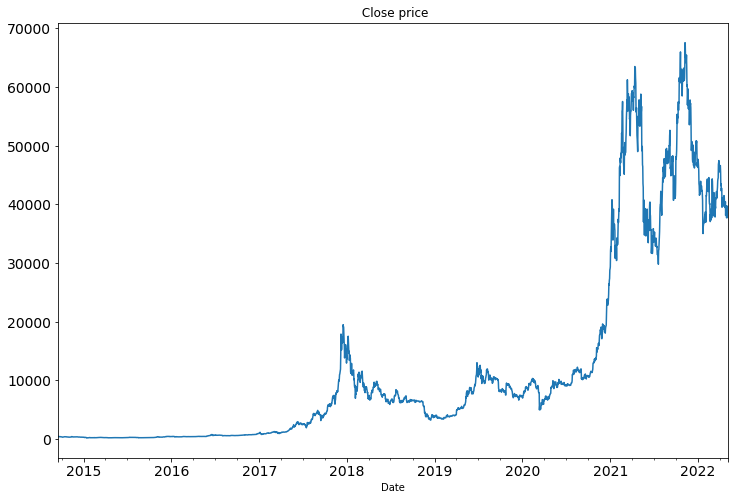

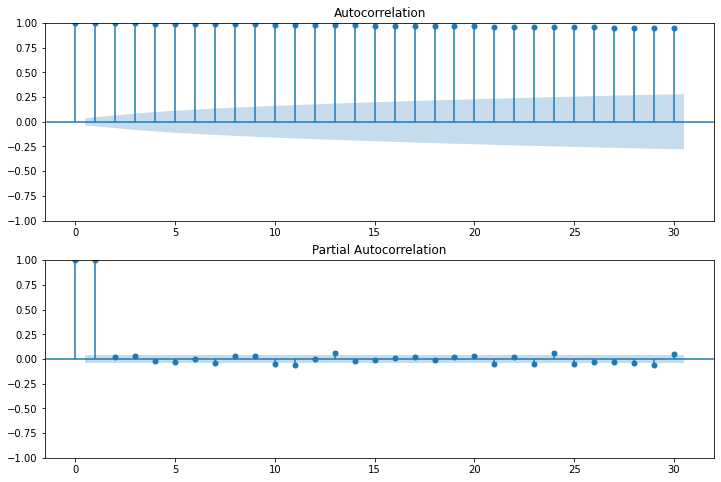

In [19]:
visualize_ts(data_transformations['original'], lags=lags)

### 3.3.2. Série Log

In [20]:
visualize_ts(data_transformations['log'], prefix='log', lags=lags)

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                   -0.568331
p-value                           0.877979
#Lags Used                       10.000000
Number of Observations Used    2777.000000
Critical Value (1%)              -3.432707
Critical Value (5%)              -2.862581
Critical Value (10%)             -2.567324
dtype: float64


### 3.3.3. Diferenças 1º grau

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                -8.900613e+00
p-value                        1.174151e-14
#Lags Used                     2.800000e+01
Number of Observations Used    2.758000e+03
Critical Value (1%)           -3.432723e+00
Critical Value (5%)           -2.862589e+00
Critical Value (10%)          -2.567328e+00
dtype: float64


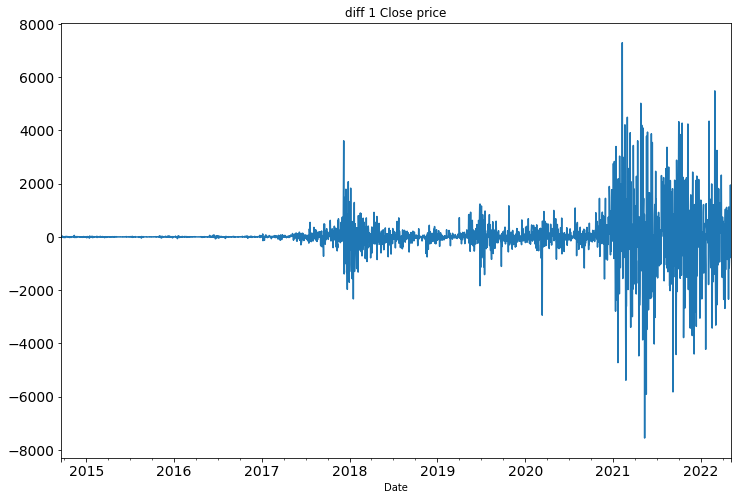

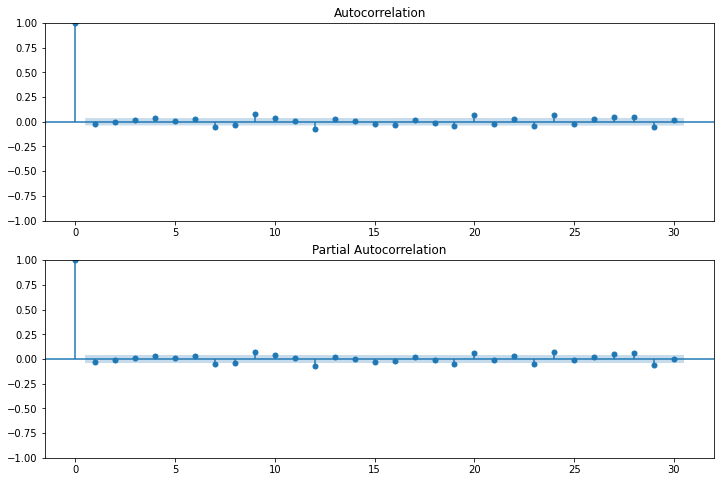

In [21]:
visualize_ts(apply_difference(dfX.Close, 1), prefix='diff 1', lags=lags)

### 3.3.4. Diferenças 1º grau Log

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                -1.592152e+01
p-value                        7.913820e-29
#Lags Used                     9.000000e+00
Number of Observations Used    2.777000e+03
Critical Value (1%)           -3.432707e+00
Critical Value (5%)           -2.862581e+00
Critical Value (10%)          -2.567324e+00
dtype: float64


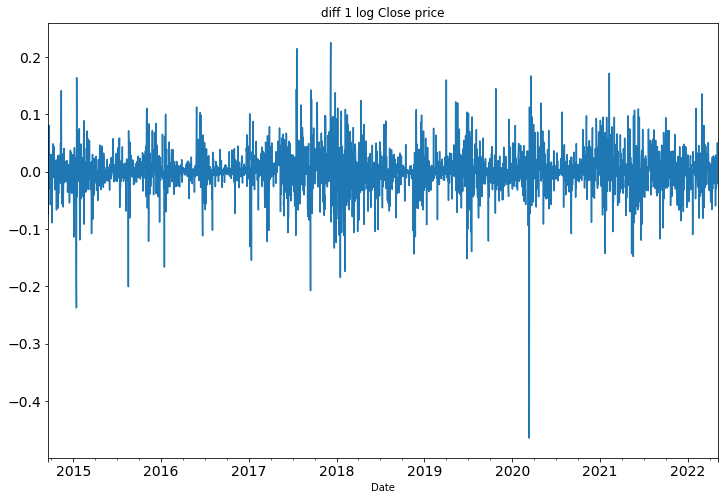

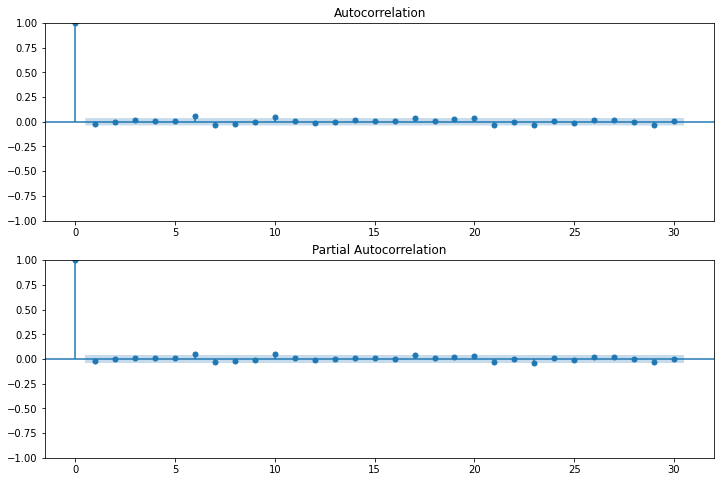

In [22]:
visualize_ts(apply_difference(dfX.Close.map(np.log), 1), prefix='diff 1 log')

### 3.3.5. Diferenças sazonais

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                   -1.967225
p-value                           0.301126
#Lags Used                       27.000000
Number of Observations Used    2395.000000
Critical Value (1%)              -3.433083
Critical Value (5%)              -2.862748
Critical Value (10%)             -2.567413
dtype: float64


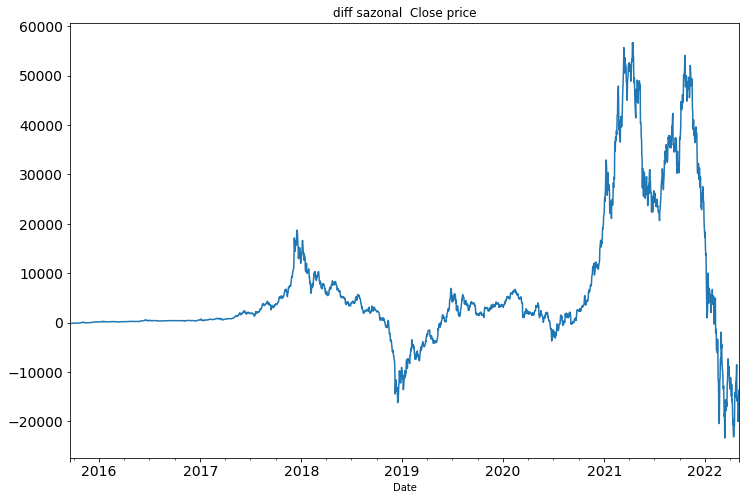

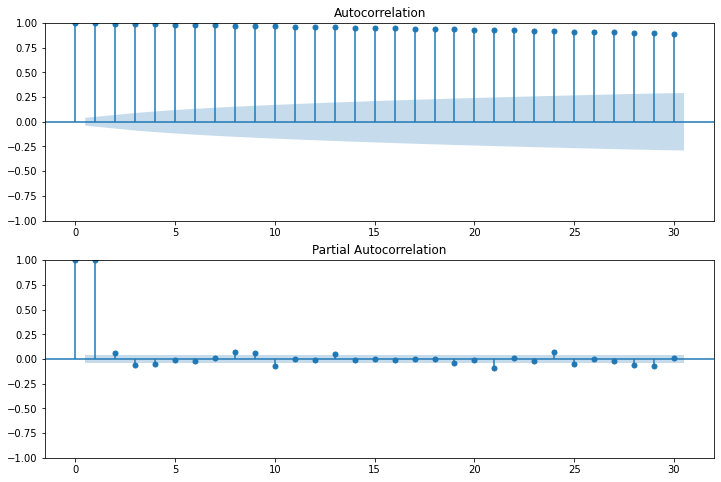

In [23]:
visualize_ts(apply_difference(dfX.Close, period), prefix='diff sazonal ')

### 3.3.6. Diferenças sazonais Log

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                   -1.761582
p-value                           0.399695
#Lags Used                        0.000000
Number of Observations Used    2422.000000
Critical Value (1%)              -3.433053
Critical Value (5%)              -2.862734
Critical Value (10%)             -2.567406
dtype: float64


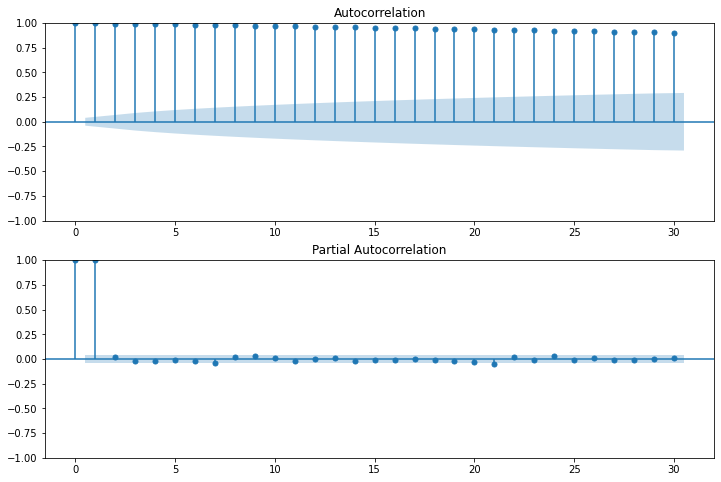

In [24]:
visualize_ts(apply_difference(dfX.Close.map(np.log), period), prefix=f'diff sazonal Log')

### 3.3.7 Diferenças sazonais 1º grau

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                -7.002319e+00
p-value                        7.268491e-10
#Lags Used                     2.700000e+01
Number of Observations Used    2.394000e+03
Critical Value (1%)           -3.433084e+00
Critical Value (5%)           -2.862748e+00
Critical Value (10%)          -2.567413e+00
dtype: float64


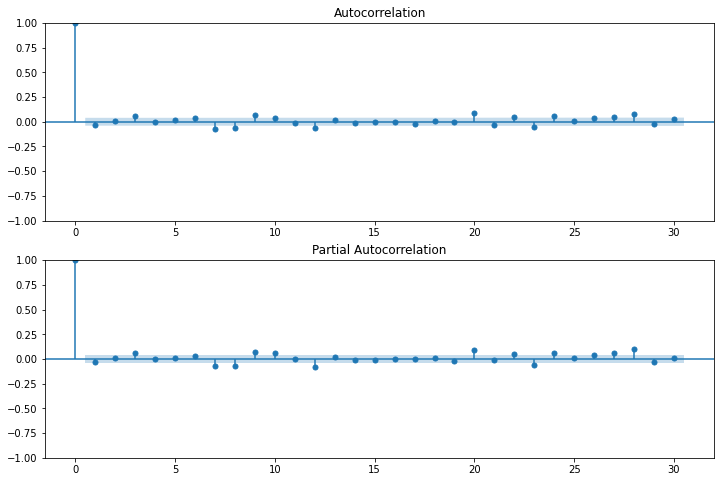

In [25]:
visualize_ts(apply_difference(apply_difference(dfX.Close, 1), period),
             prefix=f'diff sazonal 1º grau')

### 3.3.8. DIferenças sazonais 1º grau log

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


Results of Dickey-Fuller Test:
Test Statistic                -1.475301e+01
p-value                        2.468237e-27
#Lags Used                     9.000000e+00
Number of Observations Used    2.412000e+03
Critical Value (1%)           -3.433064e+00
Critical Value (5%)           -2.862739e+00
Critical Value (10%)          -2.567408e+00
dtype: float64


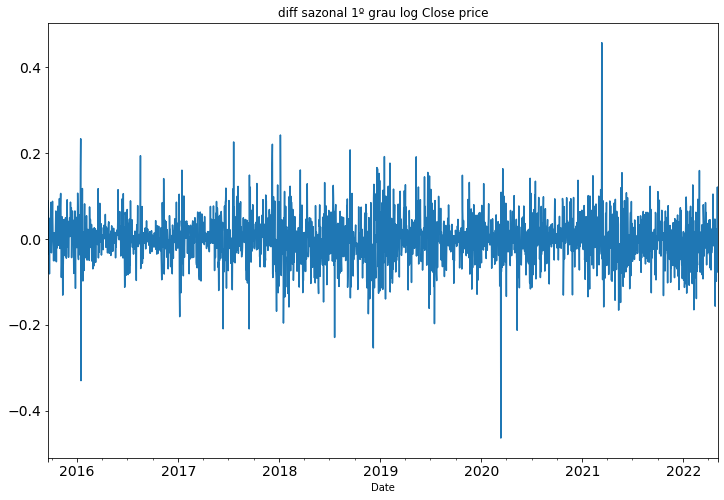

In [26]:
visualize_ts(apply_difference(apply_difference(dfX.Close.map(np.log), 1), period),
             prefix='diff sazonal 1º grau log')

# 4. Modelos

## 4.1. Prepare grid search for ARIMA and ARIMAX

In [80]:
data_labels = list(data_transformations.keys())
# non seasonality
p = range(0,5,1)
d = 1
q = range(0,10,1)

# seasonality
P = range(0,5,1)
D = 1
Q = range(0,10,1)

In [28]:
import tqdm
from itertools import product
import pickle

In [29]:
len(list(product(data_labels,p,q)))

400

In [30]:
len(list(product(data_labels,p,q,P,Q)))

20000

## 4.2. ARIMA

In [63]:
def optimize_ARIMA(parameters_list, d, filename=None):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        ts - time series
        file - if present, write results to file in append mode
    """
    
    best_param = ()
    best_aic = None
    
    print('starting...')
    for i, param in enumerate(parameters_list):
        print(i, param, 'best:', best_param, best_aic, )
        try:
            model = ARIMA(endog=data_transformations[param[0]],
                          order=(param[1], d, param[2]))
            model_fit = model.fit()
        except e:
            print('got error at ', i, 'param:', param, 'd:', d, 'exception:', e)
            continue

        results = {}
        results['params'] = param
        results['model_fit'] = model_fit
        
        if i == 0:
            best_aic = model_fit.aic
            best_param = param
            
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_param = param
            
        if filename is not None:
            pickle.dump(q, open(filename,"ab"))

In [65]:
optimize_ARIMA(product(data_labels,p,q), d, filename='arima_optimize.pkl')

starting...
0 ('original', 0, 0) best: () None
1 ('original', 0, 1) best: ('original', 0, 0) 45129.57014865705
2 ('original', 0, 2) best: ('original', 0, 0) 45129.57014865705
3 ('original', 0, 3) best: ('original', 0, 0) 45129.57014865705
4 ('original', 0, 4) best: ('original', 0, 0) 45129.57014865705
5 ('original', 0, 5) best: ('original', 0, 0) 45129.57014865705
6 ('original', 0, 6) best: ('original', 0, 0) 45129.57014865705
7 ('original', 0, 7) best: ('original', 0, 0) 45129.57014865705
8 ('original', 0, 8) best: ('original', 0, 7) 45127.47280680846
9 ('original', 0, 9) best: ('original', 0, 8) 45127.315694658726
10 ('original', 1, 0) best: ('original', 0, 9) 45109.51341876082
11 ('original', 1, 1) best: ('original', 0, 9) 45109.51341876082
12 ('original', 1, 2) best: ('original', 0, 9) 45109.51341876082
13 ('original', 1, 3) best: ('original', 0, 9) 45109.51341876082
14 ('original', 1, 4) best: ('original', 0, 9) 45109.51341876082
15 ('original', 1, 5) best: ('original', 0, 9) 4510

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


22 ('original', 2, 2) best: ('original', 1, 9) 45108.6907322396
23 ('original', 2, 3) best: ('original', 2, 2) 45104.66757619738
24 ('original', 2, 4) best: ('original', 2, 2) 45104.66757619738
25 ('original', 2, 5) best: ('original', 2, 4) 45104.14199762794
26 ('original', 2, 6) best: ('original', 2, 4) 45104.14199762794
27 ('original', 2, 7) best: ('original', 2, 6) 45103.20066529913
28 ('original', 2, 8) best: ('original', 2, 7) 45102.28957136162
29 ('original', 2, 9) best: ('original', 2, 8) 45102.05908282869
30 ('original', 3, 0) best: ('original', 2, 9) 45101.18053515955
31 ('original', 3, 1) best: ('original', 2, 9) 45101.18053515955
32 ('original', 3, 2) best: ('original', 2, 9) 45101.18053515955


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


33 ('original', 3, 3) best: ('original', 2, 9) 45101.18053515955
34 ('original', 3, 4) best: ('original', 2, 9) 45101.18053515955


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


35 ('original', 3, 5) best: ('original', 2, 9) 45101.18053515955
36 ('original', 3, 6) best: ('original', 2, 9) 45101.18053515955


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


37 ('original', 3, 7) best: ('original', 2, 9) 45101.18053515955
38 ('original', 3, 8) best: ('original', 2, 9) 45101.18053515955
39 ('original', 3, 9) best: ('original', 2, 9) 45101.18053515955
40 ('original', 4, 0) best: ('original', 2, 9) 45101.18053515955
41 ('original', 4, 1) best: ('original', 2, 9) 45101.18053515955
42 ('original', 4, 2) best: ('original', 2, 9) 45101.18053515955
43 ('original', 4, 3) best: ('original', 2, 9) 45101.18053515955
44 ('original', 4, 4) best: ('original', 2, 9) 45101.18053515955


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


45 ('original', 4, 5) best: ('original', 4, 4) 45091.8515610137
46 ('original', 4, 6) best: ('original', 4, 4) 45091.8515610137


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


47 ('original', 4, 7) best: ('original', 4, 4) 45091.8515610137


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


48 ('original', 4, 8) best: ('original', 4, 7) 45081.22351634299


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


49 ('original', 4, 9) best: ('original', 4, 7) 45081.22351634299
50 ('log', 0, 0) best: ('original', 4, 7) 45081.22351634299


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


51 ('log', 0, 1) best: ('log', 0, 0) -10167.017366961765
52 ('log', 0, 2) best: ('log', 0, 0) -10167.017366961765
53 ('log', 0, 3) best: ('log', 0, 0) -10167.017366961765
54 ('log', 0, 4) best: ('log', 0, 0) -10167.017366961765
55 ('log', 0, 5) best: ('log', 0, 0) -10167.017366961765
56 ('log', 0, 6) best: ('log', 0, 0) -10167.017366961765
57 ('log', 0, 7) best: ('log', 0, 0) -10167.017366961765
58 ('log', 0, 8) best: ('log', 0, 0) -10167.017366961765
59 ('log', 0, 9) best: ('log', 0, 0) -10167.017366961765
60 ('log', 1, 0) best: ('log', 0, 0) -10167.017366961765
61 ('log', 1, 1) best: ('log', 0, 0) -10167.017366961765
62 ('log', 1, 2) best: ('log', 0, 0) -10167.017366961765
63 ('log', 1, 3) best: ('log', 0, 0) -10167.017366961765
64 ('log', 1, 4) best: ('log', 0, 0) -10167.017366961765
65 ('log', 1, 5) best: ('log', 0, 0) -10167.017366961765
66 ('log', 1, 6) best: ('log', 0, 0) -10167.017366961765
67 ('log', 1, 7) best: ('log', 0, 0) -10167.017366961765
68 ('log', 1, 8) best: ('log', 

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


72 ('log', 2, 2) best: ('log', 0, 0) -10167.017366961765


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


73 ('log', 2, 3) best: ('log', 0, 0) -10167.017366961765
74 ('log', 2, 4) best: ('log', 0, 0) -10167.017366961765
75 ('log', 2, 5) best: ('log', 0, 0) -10167.017366961765
76 ('log', 2, 6) best: ('log', 0, 0) -10167.017366961765
77 ('log', 2, 7) best: ('log', 0, 0) -10167.017366961765


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


78 ('log', 2, 8) best: ('log', 2, 7) -10167.232884826608
79 ('log', 2, 9) best: ('log', 2, 7) -10167.232884826608
80 ('log', 3, 0) best: ('log', 2, 7) -10167.232884826608
81 ('log', 3, 1) best: ('log', 2, 7) -10167.232884826608
82 ('log', 3, 2) best: ('log', 2, 7) -10167.232884826608


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


83 ('log', 3, 3) best: ('log', 2, 7) -10167.232884826608
84 ('log', 3, 4) best: ('log', 2, 7) -10167.232884826608


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


85 ('log', 3, 5) best: ('log', 2, 7) -10167.232884826608


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


86 ('log', 3, 6) best: ('log', 2, 7) -10167.232884826608
87 ('log', 3, 7) best: ('log', 3, 6) -10168.640837642713
88 ('log', 3, 8) best: ('log', 3, 6) -10168.640837642713
89 ('log', 3, 9) best: ('log', 3, 6) -10168.640837642713
90 ('log', 4, 0) best: ('log', 3, 6) -10168.640837642713
91 ('log', 4, 1) best: ('log', 3, 6) -10168.640837642713
92 ('log', 4, 2) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


93 ('log', 4, 3) best: ('log', 3, 6) -10168.640837642713
94 ('log', 4, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


95 ('log', 4, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


96 ('log', 4, 6) best: ('log', 3, 6) -10168.640837642713
97 ('log', 4, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


98 ('log', 4, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


99 ('log', 4, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


100 ('diff_1', 0, 0) best: ('log', 3, 6) -10168.640837642713
101 ('diff_1', 0, 1) best: ('log', 3, 6) -10168.640837642713
102 ('diff_1', 0, 2) best: ('log', 3, 6) -10168.640837642713
103 ('diff_1', 0, 3) best: ('log', 3, 6) -10168.640837642713
104 ('diff_1', 0, 4) best: ('log', 3, 6) -10168.640837642713
105 ('diff_1', 0, 5) best: ('log', 3, 6) -10168.640837642713
106 ('diff_1', 0, 6) best: ('log', 3, 6) -10168.640837642713
107 ('diff_1', 0, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


108 ('diff_1', 0, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


109 ('diff_1', 0, 9) best: ('log', 3, 6) -10168.640837642713
110 ('diff_1', 1, 0) best: ('log', 3, 6) -10168.640837642713
111 ('diff_1', 1, 1) best: ('log', 3, 6) -10168.640837642713
112 ('diff_1', 1, 2) best: ('log', 3, 6) -10168.640837642713
113 ('diff_1', 1, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


114 ('diff_1', 1, 4) best: ('log', 3, 6) -10168.640837642713
115 ('diff_1', 1, 5) best: ('log', 3, 6) -10168.640837642713
116 ('diff_1', 1, 6) best: ('log', 3, 6) -10168.640837642713
117 ('diff_1', 1, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


118 ('diff_1', 1, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


119 ('diff_1', 1, 9) best: ('log', 3, 6) -10168.640837642713
120 ('diff_1', 2, 0) best: ('log', 3, 6) -10168.640837642713
121 ('diff_1', 2, 1) best: ('log', 3, 6) -10168.640837642713
122 ('diff_1', 2, 2) best: ('log', 3, 6) -10168.640837642713
123 ('diff_1', 2, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


124 ('diff_1', 2, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


125 ('diff_1', 2, 5) best: ('log', 3, 6) -10168.640837642713
126 ('diff_1', 2, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


127 ('diff_1', 2, 7) best: ('log', 3, 6) -10168.640837642713
128 ('diff_1', 2, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


129 ('diff_1', 2, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


130 ('diff_1', 3, 0) best: ('log', 3, 6) -10168.640837642713
131 ('diff_1', 3, 1) best: ('log', 3, 6) -10168.640837642713
132 ('diff_1', 3, 2) best: ('log', 3, 6) -10168.640837642713
133 ('diff_1', 3, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


134 ('diff_1', 3, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


135 ('diff_1', 3, 5) best: ('log', 3, 6) -10168.640837642713
136 ('diff_1', 3, 6) best: ('log', 3, 6) -10168.640837642713
137 ('diff_1', 3, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


138 ('diff_1', 3, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


139 ('diff_1', 3, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


140 ('diff_1', 4, 0) best: ('log', 3, 6) -10168.640837642713
141 ('diff_1', 4, 1) best: ('log', 3, 6) -10168.640837642713
142 ('diff_1', 4, 2) best: ('log', 3, 6) -10168.640837642713
143 ('diff_1', 4, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


144 ('diff_1', 4, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


145 ('diff_1', 4, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


146 ('diff_1', 4, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


147 ('diff_1', 4, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


148 ('diff_1', 4, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


149 ('diff_1', 4, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


150 ('diff_1_log', 0, 0) best: ('log', 3, 6) -10168.640837642713
151 ('diff_1_log', 0, 1) best: ('log', 3, 6) -10168.640837642713
152 ('diff_1_log', 0, 2) best: ('log', 3, 6) -10168.640837642713
153 ('diff_1_log', 0, 3) best: ('log', 3, 6) -10168.640837642713
154 ('diff_1_log', 0, 4) best: ('log', 3, 6) -10168.640837642713
155 ('diff_1_log', 0, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


156 ('diff_1_log', 0, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


157 ('diff_1_log', 0, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


158 ('diff_1_log', 0, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


159 ('diff_1_log', 0, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


160 ('diff_1_log', 1, 0) best: ('log', 3, 6) -10168.640837642713
161 ('diff_1_log', 1, 1) best: ('log', 3, 6) -10168.640837642713
162 ('diff_1_log', 1, 2) best: ('log', 3, 6) -10168.640837642713
163 ('diff_1_log', 1, 3) best: ('log', 3, 6) -10168.640837642713
164 ('diff_1_log', 1, 4) best: ('log', 3, 6) -10168.640837642713
165 ('diff_1_log', 1, 5) best: ('log', 3, 6) -10168.640837642713
166 ('diff_1_log', 1, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


167 ('diff_1_log', 1, 7) best: ('log', 3, 6) -10168.640837642713
168 ('diff_1_log', 1, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


169 ('diff_1_log', 1, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


170 ('diff_1_log', 2, 0) best: ('log', 3, 6) -10168.640837642713
171 ('diff_1_log', 2, 1) best: ('log', 3, 6) -10168.640837642713
172 ('diff_1_log', 2, 2) best: ('log', 3, 6) -10168.640837642713
173 ('diff_1_log', 2, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


174 ('diff_1_log', 2, 4) best: ('log', 3, 6) -10168.640837642713
175 ('diff_1_log', 2, 5) best: ('log', 3, 6) -10168.640837642713
176 ('diff_1_log', 2, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


177 ('diff_1_log', 2, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


178 ('diff_1_log', 2, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


179 ('diff_1_log', 2, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


180 ('diff_1_log', 3, 0) best: ('log', 3, 6) -10168.640837642713
181 ('diff_1_log', 3, 1) best: ('log', 3, 6) -10168.640837642713
182 ('diff_1_log', 3, 2) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


183 ('diff_1_log', 3, 3) best: ('log', 3, 6) -10168.640837642713
184 ('diff_1_log', 3, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


185 ('diff_1_log', 3, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


186 ('diff_1_log', 3, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


187 ('diff_1_log', 3, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


188 ('diff_1_log', 3, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


189 ('diff_1_log', 3, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


190 ('diff_1_log', 4, 0) best: ('log', 3, 6) -10168.640837642713
191 ('diff_1_log', 4, 1) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


192 ('diff_1_log', 4, 2) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


193 ('diff_1_log', 4, 3) best: ('log', 3, 6) -10168.640837642713
194 ('diff_1_log', 4, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


195 ('diff_1_log', 4, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


196 ('diff_1_log', 4, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


197 ('diff_1_log', 4, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


198 ('diff_1_log', 4, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


199 ('diff_1_log', 4, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


200 ('diff_saz', 0, 0) best: ('log', 3, 6) -10168.640837642713
201 ('diff_saz', 0, 1) best: ('log', 3, 6) -10168.640837642713
202 ('diff_saz', 0, 2) best: ('log', 3, 6) -10168.640837642713
203 ('diff_saz', 0, 3) best: ('log', 3, 6) -10168.640837642713
204 ('diff_saz', 0, 4) best: ('log', 3, 6) -10168.640837642713
205 ('diff_saz', 0, 5) best: ('log', 3, 6) -10168.640837642713
206 ('diff_saz', 0, 6) best: ('log', 3, 6) -10168.640837642713
207 ('diff_saz', 0, 7) best: ('log', 3, 6) -10168.640837642713
208 ('diff_saz', 0, 8) best: ('log', 3, 6) -10168.640837642713
209 ('diff_saz', 0, 9) best: ('log', 3, 6) -10168.640837642713
210 ('diff_saz', 1, 0) best: ('log', 3, 6) -10168.640837642713
211 ('diff_saz', 1, 1) best: ('log', 3, 6) -10168.640837642713
212 ('diff_saz', 1, 2) best: ('log', 3, 6) -10168.640837642713
213 ('diff_saz', 1, 3) best: ('log', 3, 6) -10168.640837642713
214 ('diff_saz', 1, 4) best: ('log', 3, 6) -10168.640837642713
215 ('diff_saz', 1, 5) best: ('log', 3, 6) -10168.64083

/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


222 ('diff_saz', 2, 2) best: ('log', 3, 6) -10168.640837642713
223 ('diff_saz', 2, 3) best: ('log', 3, 6) -10168.640837642713
224 ('diff_saz', 2, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


225 ('diff_saz', 2, 5) best: ('log', 3, 6) -10168.640837642713
226 ('diff_saz', 2, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


227 ('diff_saz', 2, 7) best: ('log', 3, 6) -10168.640837642713
228 ('diff_saz', 2, 8) best: ('log', 3, 6) -10168.640837642713
229 ('diff_saz', 2, 9) best: ('log', 3, 6) -10168.640837642713
230 ('diff_saz', 3, 0) best: ('log', 3, 6) -10168.640837642713
231 ('diff_saz', 3, 1) best: ('log', 3, 6) -10168.640837642713
232 ('diff_saz', 3, 2) best: ('log', 3, 6) -10168.640837642713
233 ('diff_saz', 3, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


234 ('diff_saz', 3, 4) best: ('log', 3, 6) -10168.640837642713
235 ('diff_saz', 3, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


236 ('diff_saz', 3, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


237 ('diff_saz', 3, 7) best: ('log', 3, 6) -10168.640837642713
238 ('diff_saz', 3, 8) best: ('log', 3, 6) -10168.640837642713
239 ('diff_saz', 3, 9) best: ('log', 3, 6) -10168.640837642713
240 ('diff_saz', 4, 0) best: ('log', 3, 6) -10168.640837642713
241 ('diff_saz', 4, 1) best: ('log', 3, 6) -10168.640837642713
242 ('diff_saz', 4, 2) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


243 ('diff_saz', 4, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


244 ('diff_saz', 4, 4) best: ('log', 3, 6) -10168.640837642713
245 ('diff_saz', 4, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


246 ('diff_saz', 4, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


247 ('diff_saz', 4, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


248 ('diff_saz', 4, 8) best: ('log', 3, 6) -10168.640837642713
249 ('diff_saz', 4, 9) best: ('log', 3, 6) -10168.640837642713
250 ('diff_saz_log', 0, 0) best: ('log', 3, 6) -10168.640837642713
251 ('diff_saz_log', 0, 1) best: ('log', 3, 6) -10168.640837642713
252 ('diff_saz_log', 0, 2) best: ('log', 3, 6) -10168.640837642713
253 ('diff_saz_log', 0, 3) best: ('log', 3, 6) -10168.640837642713
254 ('diff_saz_log', 0, 4) best: ('log', 3, 6) -10168.640837642713
255 ('diff_saz_log', 0, 5) best: ('log', 3, 6) -10168.640837642713
256 ('diff_saz_log', 0, 6) best: ('log', 3, 6) -10168.640837642713
257 ('diff_saz_log', 0, 7) best: ('log', 3, 6) -10168.640837642713
258 ('diff_saz_log', 0, 8) best: ('log', 3, 6) -10168.640837642713
259 ('diff_saz_log', 0, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


260 ('diff_saz_log', 1, 0) best: ('log', 3, 6) -10168.640837642713
261 ('diff_saz_log', 1, 1) best: ('log', 3, 6) -10168.640837642713
262 ('diff_saz_log', 1, 2) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


263 ('diff_saz_log', 1, 3) best: ('log', 3, 6) -10168.640837642713
264 ('diff_saz_log', 1, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


265 ('diff_saz_log', 1, 5) best: ('log', 3, 6) -10168.640837642713
266 ('diff_saz_log', 1, 6) best: ('log', 3, 6) -10168.640837642713
267 ('diff_saz_log', 1, 7) best: ('log', 3, 6) -10168.640837642713
268 ('diff_saz_log', 1, 8) best: ('log', 3, 6) -10168.640837642713
269 ('diff_saz_log', 1, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


270 ('diff_saz_log', 2, 0) best: ('log', 3, 6) -10168.640837642713
271 ('diff_saz_log', 2, 1) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


272 ('diff_saz_log', 2, 2) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


273 ('diff_saz_log', 2, 3) best: ('log', 3, 6) -10168.640837642713
274 ('diff_saz_log', 2, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


275 ('diff_saz_log', 2, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


276 ('diff_saz_log', 2, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


277 ('diff_saz_log', 2, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


278 ('diff_saz_log', 2, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


279 ('diff_saz_log', 2, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


280 ('diff_saz_log', 3, 0) best: ('log', 3, 6) -10168.640837642713
281 ('diff_saz_log', 3, 1) best: ('log', 3, 6) -10168.640837642713
282 ('diff_saz_log', 3, 2) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


283 ('diff_saz_log', 3, 3) best: ('log', 3, 6) -10168.640837642713
284 ('diff_saz_log', 3, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


285 ('diff_saz_log', 3, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


286 ('diff_saz_log', 3, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


287 ('diff_saz_log', 3, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


288 ('diff_saz_log', 3, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


289 ('diff_saz_log', 3, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


290 ('diff_saz_log', 4, 0) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


291 ('diff_saz_log', 4, 1) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


292 ('diff_saz_log', 4, 2) best: ('log', 3, 6) -10168.640837642713
293 ('diff_saz_log', 4, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


294 ('diff_saz_log', 4, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


295 ('diff_saz_log', 4, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


296 ('diff_saz_log', 4, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


297 ('diff_saz_log', 4, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


298 ('diff_saz_log', 4, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


299 ('diff_saz_log', 4, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


300 ('diff_saz_diff_1', 0, 0) best: ('log', 3, 6) -10168.640837642713
301 ('diff_saz_diff_1', 0, 1) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


302 ('diff_saz_diff_1', 0, 2) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


303 ('diff_saz_diff_1', 0, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


304 ('diff_saz_diff_1', 0, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


305 ('diff_saz_diff_1', 0, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


306 ('diff_saz_diff_1', 0, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


307 ('diff_saz_diff_1', 0, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


308 ('diff_saz_diff_1', 0, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


309 ('diff_saz_diff_1', 0, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


310 ('diff_saz_diff_1', 1, 0) best: ('log', 3, 6) -10168.640837642713
311 ('diff_saz_diff_1', 1, 1) best: ('log', 3, 6) -10168.640837642713
312 ('diff_saz_diff_1', 1, 2) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


313 ('diff_saz_diff_1', 1, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


314 ('diff_saz_diff_1', 1, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


315 ('diff_saz_diff_1', 1, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


316 ('diff_saz_diff_1', 1, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


317 ('diff_saz_diff_1', 1, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


318 ('diff_saz_diff_1', 1, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


319 ('diff_saz_diff_1', 1, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


320 ('diff_saz_diff_1', 2, 0) best: ('log', 3, 6) -10168.640837642713
321 ('diff_saz_diff_1', 2, 1) best: ('log', 3, 6) -10168.640837642713
322 ('diff_saz_diff_1', 2, 2) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


323 ('diff_saz_diff_1', 2, 3) best: ('log', 3, 6) -10168.640837642713
324 ('diff_saz_diff_1', 2, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


325 ('diff_saz_diff_1', 2, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


326 ('diff_saz_diff_1', 2, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


327 ('diff_saz_diff_1', 2, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


328 ('diff_saz_diff_1', 2, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


329 ('diff_saz_diff_1', 2, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


330 ('diff_saz_diff_1', 3, 0) best: ('log', 3, 6) -10168.640837642713
331 ('diff_saz_diff_1', 3, 1) best: ('log', 3, 6) -10168.640837642713
332 ('diff_saz_diff_1', 3, 2) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


333 ('diff_saz_diff_1', 3, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


334 ('diff_saz_diff_1', 3, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


335 ('diff_saz_diff_1', 3, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


336 ('diff_saz_diff_1', 3, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


337 ('diff_saz_diff_1', 3, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


338 ('diff_saz_diff_1', 3, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


339 ('diff_saz_diff_1', 3, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


340 ('diff_saz_diff_1', 4, 0) best: ('log', 3, 6) -10168.640837642713
341 ('diff_saz_diff_1', 4, 1) best: ('log', 3, 6) -10168.640837642713
342 ('diff_saz_diff_1', 4, 2) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


343 ('diff_saz_diff_1', 4, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


344 ('diff_saz_diff_1', 4, 4) best: ('log', 3, 6) -10168.640837642713
345 ('diff_saz_diff_1', 4, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


346 ('diff_saz_diff_1', 4, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


347 ('diff_saz_diff_1', 4, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


348 ('diff_saz_diff_1', 4, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


349 ('diff_saz_diff_1', 4, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


350 ('diff_saz_diff_1_log', 0, 0) best: ('log', 3, 6) -10168.640837642713
351 ('diff_saz_diff_1_log', 0, 1) best: ('log', 3, 6) -10168.640837642713
352 ('diff_saz_diff_1_log', 0, 2) best: ('log', 3, 6) -10168.640837642713
353 ('diff_saz_diff_1_log', 0, 3) best: ('log', 3, 6) -10168.640837642713
354 ('diff_saz_diff_1_log', 0, 4) best: ('log', 3, 6) -10168.640837642713
355 ('diff_saz_diff_1_log', 0, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


356 ('diff_saz_diff_1_log', 0, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


357 ('diff_saz_diff_1_log', 0, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


358 ('diff_saz_diff_1_log', 0, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


359 ('diff_saz_diff_1_log', 0, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


360 ('diff_saz_diff_1_log', 1, 0) best: ('log', 3, 6) -10168.640837642713
361 ('diff_saz_diff_1_log', 1, 1) best: ('log', 3, 6) -10168.640837642713
362 ('diff_saz_diff_1_log', 1, 2) best: ('log', 3, 6) -10168.640837642713
363 ('diff_saz_diff_1_log', 1, 3) best: ('log', 3, 6) -10168.640837642713
364 ('diff_saz_diff_1_log', 1, 4) best: ('log', 3, 6) -10168.640837642713
365 ('diff_saz_diff_1_log', 1, 5) best: ('log', 3, 6) -10168.640837642713
366 ('diff_saz_diff_1_log', 1, 6) best: ('log', 3, 6) -10168.640837642713
367 ('diff_saz_diff_1_log', 1, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


368 ('diff_saz_diff_1_log', 1, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


369 ('diff_saz_diff_1_log', 1, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


370 ('diff_saz_diff_1_log', 2, 0) best: ('log', 3, 6) -10168.640837642713
371 ('diff_saz_diff_1_log', 2, 1) best: ('log', 3, 6) -10168.640837642713
372 ('diff_saz_diff_1_log', 2, 2) best: ('log', 3, 6) -10168.640837642713
373 ('diff_saz_diff_1_log', 2, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


374 ('diff_saz_diff_1_log', 2, 4) best: ('log', 3, 6) -10168.640837642713
375 ('diff_saz_diff_1_log', 2, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


376 ('diff_saz_diff_1_log', 2, 6) best: ('log', 3, 6) -10168.640837642713
377 ('diff_saz_diff_1_log', 2, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


378 ('diff_saz_diff_1_log', 2, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


379 ('diff_saz_diff_1_log', 2, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


380 ('diff_saz_diff_1_log', 3, 0) best: ('log', 3, 6) -10168.640837642713
381 ('diff_saz_diff_1_log', 3, 1) best: ('log', 3, 6) -10168.640837642713
382 ('diff_saz_diff_1_log', 3, 2) best: ('log', 3, 6) -10168.640837642713
383 ('diff_saz_diff_1_log', 3, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


384 ('diff_saz_diff_1_log', 3, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


385 ('diff_saz_diff_1_log', 3, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


386 ('diff_saz_diff_1_log', 3, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


387 ('diff_saz_diff_1_log', 3, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


388 ('diff_saz_diff_1_log', 3, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


389 ('diff_saz_diff_1_log', 3, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


390 ('diff_saz_diff_1_log', 4, 0) best: ('log', 3, 6) -10168.640837642713
391 ('diff_saz_diff_1_log', 4, 1) best: ('log', 3, 6) -10168.640837642713
392 ('diff_saz_diff_1_log', 4, 2) best: ('log', 3, 6) -10168.640837642713
393 ('diff_saz_diff_1_log', 4, 3) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


394 ('diff_saz_diff_1_log', 4, 4) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


395 ('diff_saz_diff_1_log', 4, 5) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


396 ('diff_saz_diff_1_log', 4, 6) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


397 ('diff_saz_diff_1_log', 4, 7) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


398 ('diff_saz_diff_1_log', 4, 8) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


399 ('diff_saz_diff_1_log', 4, 9) best: ('log', 3, 6) -10168.640837642713


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


## 4.3. SARIMA

### 4.3.1. média mensal, previsão anual

Para o SARIMA, uma sazonalidade de 365 dias cria modelos que são demasiado grandes e demoram demasiado tempo.
Por essa razão modulámos os dados para fazer uma predição com dados semanais.

In [84]:
dfMonth = dfX.resample("M").mean()

period = 12

In [93]:
dfWeek = dfX.resample("W").mean()

period = 52

In [95]:
xx = dfWeek

data_transformations_Month = {
    'original': xx.Close,
    'log': xx.Close.map(np.log),
}

In [108]:
def optimize_SARIMA(parameters_list, d, D, s, filename=None):
    """
        Return dataframe with parameters, corresponding AIC and SSE
        
        parameters_list - list with (p, q, P, Q) tuples
        d - integration order
        D - seasonal integration order
        s - season length
        file - if present, write results to file in append mode
    """
    
    best_param = ()
    best_aic = None
    
    print('starting...')
    for i, param in enumerate(parameters_list):
        print(i, param, 'best:', best_param, best_aic, )
        try:
            model = ARIMA(endog=data_transformations_Month[param[0]],
                          order=(3, d, 6),
                          seasonal_order=(param[1], D, param[2], s)
                         )
            model_fit = model.fit()
        except Exception as e:
            print('got error at ', i, 'param:', param, 'd:', d, 'D:', D, 's:', s, 'exception:', e)
            continue
            

        results = {}
        results['params'] = {'QD':param, 'p':3, 'q':6, 's':s, 'd':d,'D':D}
        results['aic'] = model_fit.aic
        
        if i == 0:
            best_aic = model_fit.aic
            best_param = param
            
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_param = param
            
        if filename is not None:
            pickle.dump(results, open(filename,"ab"))

O espaço paramétrico conta com 5000 opções.
Vamos usar para p e q os melhores valores encontrados na optimização do ARIMA.
Isto reduz o espaço para 100 opções.

In [102]:
%%time
model = ARIMA(endog=data_transformations_Month['log'],
                          order=(3, d, 6),
                          seasonal_order=(1, D, 0, period)
                         )
model_fit = model.fit()

CPU times: user 3min 37s, sys: 2min 19s, total: 5min 56s
Wall time: 44.7 s


In [ ]:
param_space = product(data_transformations_Month.keys(),
                      P,
                      Q)
optimize_SARIMA(param_space, d, D, period, filename='sarima_optimize.pkl')

starting...
0 ('original', 0, 0) best: () None


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


1 ('original', 0, 1) best: ('original', 0, 0) 6307.605010222679


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


2 ('original', 0, 2) best: ('original', 0, 1) 6245.888506685504


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:1009: UserWarning: Non-invertible starting seasonal moving average Using zeros as starting parameters.
  warn('Non-invertible starting seasonal moving average'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


3 ('original', 0, 3) best: ('original', 0, 2) 6229.37274943227


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


4 ('original', 0, 4) best: ('original', 0, 2) 6229.37274943227


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


5 ('original', 0, 5) best: ('original', 0, 2) 6229.37274943227


/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/tsa/statespace/sarimax.py:866: UserWarning: Too few observations to estimate starting parameters for seasonal ARMA. All parameters except for variances will be set to zeros.
  warn('Too few observations to estimate starting parameters%s.'
/home/ciafa/mnt_point/.dasilva/timeseriesforecasting/.venv/lib/python3.8/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


In [5]:
import pickle

In [ ]:
pickle.load(

In [32]:
with open('sarima_optimize.pkl', 'rb') as f:
    objs = []
    while True:
        try:
            o = pickle.load(f)
        except EOFError:
            break
        objs.append(o)

In [33]:
objs

[{'params': {'QD': ('original', 0, 0),
   'p': 1,
   'q': 3,
   's': 52,
   'd': 1,
   'D': 1},
  'aic': 6307.605010222679},
 {'params': {'QD': ('original', 0, 1),
   'p': 1,
   'q': 3,
   's': 52,
   'd': 1,
   'D': 1},
  'aic': 6245.888506685504},
 {'params': {'QD': ('original', 0, 2),
   'p': 1,
   'q': 3,
   's': 52,
   'd': 1,
   'D': 1},
  'aic': 6229.37274943227},
 {'params': {'QD': ('original', 0, 3),
   'p': 1,
   'q': 3,
   's': 52,
   'd': 1,
   'D': 1},
  'aic': 6239.319333057687},
 {'params': {'QD': ('original', 0, 4),
   'p': 1,
   'q': 3,
   's': 52,
   'd': 1,
   'D': 1},
  'aic': 6240.566781495132},
 {'params': {'QD': ('original', 0, 5),
   'p': 1,
   'q': 3,
   's': 52,
   'd': 1,
   'D': 1},
  'aic': 6230.7247759231595},
 {'params': {'QD': ('original', 0, 6),
   'p': 1,
   'q': 3,
   's': 52,
   'd': 1,
   'D': 1},
  'aic': 6237.579175573921},
 {'params': {'QD': ('original', 0, 7),
   'p': 1,
   'q': 3,
   's': 52,
   'd': 1,
   'D': 1},
  'aic': 6224.251574895587},


In [31]:
objs

{'params': {'QD': ('original', 0, 0), 'p': 1, 'q': 3, 's': 52, 'd': 1, 'D': 1},
 'aic': 6307.605010222679}

# ----------------------------------------------------------

In [ ]:
visualize_ts(dfX.iloc[int(-365*1.5):], lags=lagsX, lags=lags)

In [ ]:
visualize_ts(dfX.map(np.log))

Pela análise da série temporal, podemos fazer uma divisão, essencialmente, em 3 partes.
A primeira parte, cobrindo o período até um pouco antes de 2017, aparenta te uma baixa variância, em comparação com a restante série.

Entre 2017 e o início de 2018, o preço tem uma subida acentuada (seguinda de uma descida elevada).
A partir desse momento, e até ao final de 2020, o preço não volta a descer para os valores anteriores.
Adicionalmente, a variância é muito superior ao que se observa no periodo anterior.

Finalmente, no final de 2020, volta a ocorrer outra subida acentuada (seguida, também, de outra descida).
Novamente, o preço não volta a cair para os valores observados no período anterior.
É um período marcado por outra subida na variância.

A série não apresenta sazonalidade, mas é claramente não estacionária.

Iremos proceder a uma análise mais detalhada destas 3 partes.

In [ ]:
start1, end1 = '2014-09-17', '2017-05-01'
start2, end2 = '2017-06-01', '2020-11-01'
start3, end3 = '2020-12-01', '2022-05-05'

part1 = dfX.loc[start1:end1]
part2 = dfX.loc[start2:end2]
part3 = dfX.loc[start3:end3]

In [ ]:
plt.figure(figsize=(12,8))
part1.plot(title=f'Part 1, std={part1.std()}')
plt.figure(figsize=(12,8))
part2.plot(title=f'Part 2, std={part2.std()}')
plt.figure(figsize=(12,8))
part3.plot(title=f'Part 3, std={part3.std()}')

In [ ]:
visualize_ts(part1, prefix='Part 1 -')

In [ ]:
visualize_ts(part2, prefix='Part 2 -')

In [ ]:
visualize_ts(part3, prefix='Part 3 -')

Através de uma análise mais detalhada aos 3 períodos referidos, as observações anteriores tornam-se mais explicitas.

Em cada transição de período, o desvio padrão aumenta em uma ordem de magnitude.

Os gráficos do factor de autocorrelação demonstram um perfil diferente em cada período.
No primeiro periodo, a autocorreção no periodo em estudo (_lags_ de 30 dias) é muito alto.
No segundo, observamos um ligeiro decaimento.
No terceiro, o decaimento é mais acentuado.

Este comportamento seria de esperar tendo em conta a mudança do comportamento da variância nos intervalos identificados.

O fator de autocorrelação parcial, por outro lado, demonstra sempre o mesmo comportamento.
A correlação com o segundo lag é muito alta, mas as restantes são muito baixas.

## 3.2. Transformações

### Testes às séries

In [ ]:
# Unit root tests
def adf_test(timeseries):
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(timeseries, autolag="AIC")
    dfoutput = pd.Series(
        dftest[0:4],
        index=[
            "Test Statistic",
            "p-value",
            "#Lags Used",
            "Number of Observations Used",
        ],
    )
    for key, value in dftest[4].items():
        dfoutput["Critical Value (%s)" % key] = value
    print(dfoutput)
    
def kpss_test(timeseries):
    print("Results of KPSS Test:")
    kpsstest = kpss(timeseries, regression="c", nlags="auto")
    kpss_output = pd.Series(
        kpsstest[0:3], index=["Test Statistic", "p-value", "Lags Used"]
    )
    for key, value in kpsstest[3].items():
        kpss_output["Critical Value (%s)" % key] = value
    print(kpss_output)
        

        
def stationary_tests(x, comment=''):
    print('\t', comment, '\n')
    print(adf_test(x))
    print(kpss_test(x))

In [ ]:
stationary_tests(dfX, 'original series')

In [ ]:
dfX.map(np.log).plot(figsize=(12,8), title= 'Logarithm of close price', fontsize=14)
stationary_tests(dfX.map(np.log), 'log series')

De acordo com os testes (ADF e KPSS), a série original e o logaritmo da série apresentam comportamento não estacionário.
ADF tem p>0.05, logo não podemos rejeitar hipótese nula, o que indica que a série tem raiz unitária e não é estacionária.
Vamos proceder à aplicação de diferenças e tentar torná-las estacionárias para proceder com a análise.

### Aplicação de diferenças

In [ ]:
diff1 = apply_differences(dfX, 1)
diff1.plot(figsize=(12,8), title= 'First difference', fontsize=14)
stationary_tests(diff1, 'First difference')

In [ ]:
visualize_ts(diff1)

In [ ]:
diff1_log = apply_differences(dfX.map(np.log), 1)
visualize_ts(diff1_log, prefix='diff 1 log ')
stationary_tests(diff1, 'First difference log')

Após **uma** aplicação de diferenças, ambas as séries tornaram-se estacionárias.
Como não apresentam tendência nem sazonalidade, não são necessárias mais transformações.

A série resultante da aplicação de diferenças ao logatimo da série original revela um comportamento mais aproximado de _random walk_ que o das diferenças aplicadas diretamente à série.

## 3.3. Modelos ARIMA

### Model form diff1 series

In [ ]:
def run_model(fd, order, lags, prefix=''):
    train = fd.iloc[:-lags]
    test = fd.iloc[-lags:]
    
    n_samples = fd.shape[0]

    model = ARIMA(endog=train, order=order, freq='D')

    model_fit = model.fit()
    printc(model_fit.summary())


    plt.figure(figsize=(12,8))
    residuals = pd.DataFrame(model_fit.resid)
    residuals.plot(figsize=(12,8), title=f'{prefix} ARIMA({order}) Residual Error Line Plot')

    plt.figure(figsize=(12,8))
    residuals.plot(kind='kde', figsize=(12,8), title=f'{prefix} ARIMA({order}) Error Density Plot')

    print(f'\n\n{prefix} ARIMA({order}) distribution')
    print(residuals.describe())

    # predict
    train_pred = model_fit.predict(start=n_samples-2*lags, end=n_samples-lags-1, dynamic=True)
    print(train_pred)
    
    plt.figure(figsize=(12,8))
    train.iloc[-lags:].plot(label='true')
    train_pred.plot(label='predicted')
    plt.legend()

    rmse = sqrt(mean_squared_error(train.iloc[n_samples-2*lags:n_samples-lags], train_pred))
    print(f'\n\n{prefix} ARIMA({order}) RMSE: {rmse}')
    
    future_dates=[dfX.index[-1]+ DateOffset(days=x)for x in range(0,30)]
    future_datest_df=pd.DataFrame(index=future_dates[1:])
    future_df=pd.concat([dfX,future_datest_df])
    future_df
    
    return model_fit

In [ ]:
dfX.groupby(dfX.index.week).mean().plot()

In [ ]:
dfX.groupby(dfX.index.month).mean().plot()

In [ ]:
dfX.groupby(dfX.index.dayofweek).mean().plot()

In [ ]:
dfX.groupby(dfX.index.year).mean().plot()

In [ ]:
dfX.groupby(dfX.index.dayofyear).mean().plot()

In [ ]:
dfX.resample('W').mean()

In [ ]:
dfX.resample('M').mean()

In [ ]:
mf = run_model(dfX, (30,1,1), lagsX)

In [ ]:
dfX.groupby(dfX.index.quarter).plot()
plt.legend()

In [ ]:
dfX.shape

In [ ]:
mf.predict(start=2788-30, end=2788)

Os residuos têm média zero e apresentam distribuição aproxaximadamente Gaussiana.

In [ ]:
run_model(dfX.map(np.log), (1,0,0), lagsX)

### Model from diff 1 log series

In [ ]:
y = dfX.iloc[:-lagsX].map(np.log)
y_true = dfX.iloc[-lagsX:].map(np.log)

In [ ]:
model = ARIMA(endog=dfX.map(np.log), order=(1,0,1))

## 3.4. Prophet

In [ ]:
import prophet

In [ ]:
dfXX = pd.DataFrame()
dfXX['ds'] = dfX.index.values
dfXX['y'] = dfX.values

In [ ]:
model = prophet.Prophet()
model.fit(dfXX.iloc[:-30])

future = model.make_future_dataframe(periods=30)

forecast = model.predict(future)
model.plot(forecast)
dfX.plot()
plt.legend()

In [ ]:
future

In [ ]:
future

In [ ]:
forecast

In [ ]:
sqrt(mean_squared_error(forecast['yhat'], dfX))

## 3.5. RNN

In [ ]:
import keras

# 4. Previsão anual do preço semanal

In [ ]:
df.index.month

In [ ]:
df['year'] = df.index.isocalendar().year
df['month'] = df.index.month
dfY = df.groupby(['year', 'month']).mean()['Close']

In [ ]:
dfY.index

In [ ]:
lagsY = 40

## 4.1. Exploração dos dados

In [ ]:
visualize_ts(dfY, lags=lagsY)
stationary_tests(dfY)

In [ ]:
visualize_ts(dfY.map(np.log), lags=lagsY)
stationary_tests(dfY.map(np.log))

## 4.2. Transformações

In [ ]:
diff1 = apply_differences(dfY, 1)
diff1.plot(figsize=(12,8), title= 'First difference', fontsize=14)
stationary_tests(diff1, 'First difference')

In [ ]:
diff1_log = apply_differences(dfY.map(np.log), 1)
diff1_log.plot(figsize=(12,8), title= 'First difference', fontsize=14)
stationary_tests(diff1_log, 'First difference')

## 4.3. Modelos ARIMA

## 4.4. Prophet

## 4.5. RNN

Neural Networks perform well with lots of data.
399 observations is too little.

# Reference

In [ ]:

# Log of Riders
df.riders_log= df.riders.apply(lambda x: np.log(x))  
test_stationarity(df.riders_log)
df.riders_log.plot(figsize=(12,8), title= 'Logarithm of riders', fontsize=14)

# First differences
df['first_difference'] = df.riders - df.riders.shift(1)  
test_stationarity(df.first_difference.dropna(inplace=False))
df['first_difference'].plot(figsize=(12,8), 
                            title= 'First difference', fontsize=14)

# Differences of Log
df['log_first_difference'] = df.riders_log - df.riders_log.shift(1)  
test_stationarity(df.log_first_difference.dropna(inplace=False))


# Sesaonal Differences
df['seasonal_difference'] = df.riders - df.riders.shift(12)  
test_stationarity(df.seasonal_difference.dropna(inplace=False))
df['seasonal_difference'].plot(figsize=(12,8), 
                               title= 'Sesaonal difference', fontsize=14)


# Ordinary and sesaonal differences
df['seasonal_first_difference'] = df.first_difference - df.first_difference.shift(12)  
test_stationarity(df.seasonal_first_difference.dropna(inplace=False))
df['seasonal_first_difference'].plot(figsize=(12,8), 
                                     title= 'Ordinary and seasonal differences', fontsize=14)


# Ordinary and sesaonal differences of logs
df['log_seasonal_first_difference'] = df.log_first_difference - df.log_first_difference.shift(12)  
test_stationarity(df.log_seasonal_first_difference.dropna(inplace=False))
df['log_seasonal_first_difference'].plot(figsize=(12,8), 
                                     title= 'Ordinary and seasonal differences of logarithm of riders', fontsize=14)



#####################
# ACF and PACF of stationary time series: Ordinary and sesaonal differences
# Do not include the first 13 observations
fig = plt.figure(figsize=(12,8))
ax1 = fig.add_subplot(211)
fig = sm.graphics.tsa.plot_acf(df.seasonal_first_difference.iloc[13:], 
                               lags=40, ax=ax1)
ax2 = fig.add_subplot(212)
fig = sm.graphics.tsa.plot_pacf(df.seasonal_first_difference.iloc[13:],
                                lags=40, ax=ax2)

###########################
# Fit a SARIMA(0,1,0)(0,1,1)12 model
model1 = sm.tsa.statespace.SARIMAX(df.riders, trend='n', 
                                order=(0,1,0), 
                                seasonal_order=(0,1,1,12))
results1 = model1.fit()
print(results1.summary())

#########################
# Fit a SARIMA(0,1,0)(0,1,1)12 model
model2 = sm.tsa.statespace.SARIMAX(df.riders, trend='n', 
                                order=(0,1,0), 
                                seasonal_order=(1,1,1,12))
results2 = model2.fit()
print(results2.summary())

#################
# Forecast the last 12 obs. using model2
df['forecast'] = results2.predict(start = 102, end= 114, dynamic= True)  
df[['riders', 'forecast']].plot(figsize=(12, 8)) 







  